In [13]:
import h3.api.numpy_int as h3
#import h3
import geopandas as gpd
import pandas as pd
import osmnx as ox
import numpy as np
import shapely

# Extract H3 tiling and population density for a given place

In [2]:
place_name = 'Konstanz, Germany'
city = ox.geocode_to_gdf(place_name)

In [31]:
gpkg_path = '../data/population_density/kontur_population_20231101.gpkg'
gdf = gpd.read_file(gpkg_path, bbox=city) # set bbox or it will try to load all and crash

In [32]:
gdf['h3'] = gdf['h3'].apply(h3.string_to_h3) # string_to_h3 needed for h3.api.numpy_int (faster)
gdf.head()

,h3,population,geometry
0,613044706816819199,52.0,"POLYGON ((1011923.691 6067920.049, 1011725.823..."
1,613044706814722047,138.0,"POLYGON ((1010603.513 6068159.005, 1010405.734..."
2,613044706791653375,131.0,"POLYGON ((1012056.552 6063169.538, 1011858.750..."
3,613044706789556223,81.0,"POLYGON ((1010736.869 6063408.617, 1010539.156..."
4,613044706785361919,90.0,"POLYGON ((1010143.805 6061153.274, 1009946.169..."


In [34]:
h3_resolution = h3.h3_get_resolution(gdf['h3'][0]) 

<Axes: >

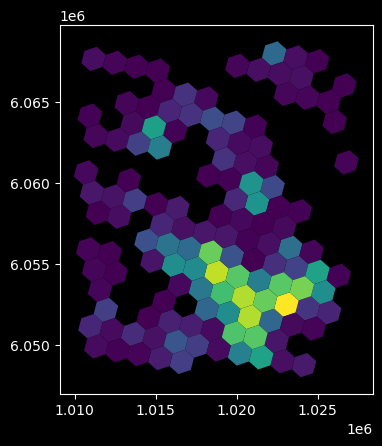

In [35]:
gdf.plot(column='population')

In [36]:
# Create an empty dataframe to write data into
h3_tiles = gpd.GeoDataFrame([],columns=['h3','geometry'])

In [37]:
# Convert multipolygon into list of polygons
def multi_to_list(multipolygon):
    l = []
    for coords in multipolygon['coordinates']:
        # quick fix, may need to be refined
        if np.ndim(coords) == 3:
            coords = coords[0]
        list_coords = [[list(x) for x in coords]]
        l.append({
            'type': 'Polygon',
            'coordinates': list_coords
        })
    return l

multipolygon = city['geometry'][0]
# Convert to GeoJSON
multipoly_geojson = gpd.GeoSeries([multipolygon]).__geo_interface__
# Parse out geometry key from GeoJSON
multipoly_geojson = multipoly_geojson['features'][0]['geometry'] 
poly_list = multi_to_list(multipoly_geojson)
for poly_geojson in poly_list:
    # Fill the dictionary with Resolution 8 H3 Hexagons
    h3_hexes = h3.polyfill_geojson(poly_geojson, h3_resolution) 
    for h3_hex in h3_hexes:
        h3_geo_boundary = shapely.geometry.Polygon(
            h3.h3_to_geo_boundary(h3_hex,geo_json=True)
        )
        # Append results to dataframe
        h3_tiles.loc[len(h3_tiles)]=[
            h3_hex,
            h3_geo_boundary,
        ]
h3_tiles = h3_tiles.set_crs(city.crs)

<Axes: >

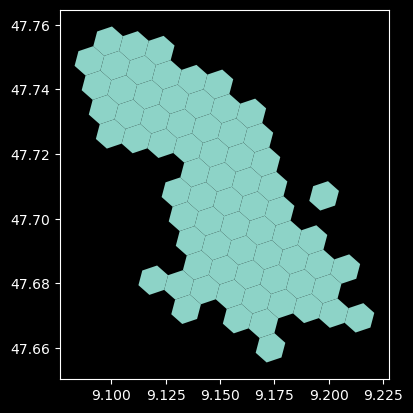

In [38]:
h3_tiles.plot()

In [39]:
# median imputation for missing values
population = gdf[gdf['h3'].isin(h3_tiles['h3'])]
no_data = h3_tiles[~h3_tiles['h3'].isin(population['h3'])]
no_data['population'] = population['population'].median()
population = population.to_crs(city.crs)
population = pd.concat([population, no_data])


/home/nicod/.local/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<Axes: >

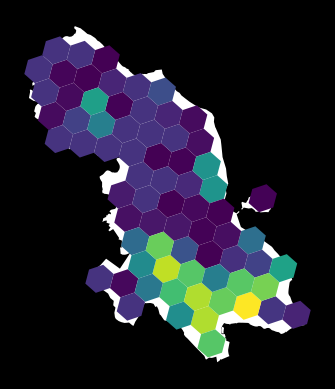

In [40]:
ax = city.plot(color='white')
ax.set_axis_off()
population.plot(ax=ax, zorder=1, column='population')

In [ ]:
#TODO extract surroundings hexagons to extend the scope to the suburb

## Package test 
(same computations as above)

In [1]:
# auto reload package
%load_ext autoreload
%autoreload 2
from od.place import Place

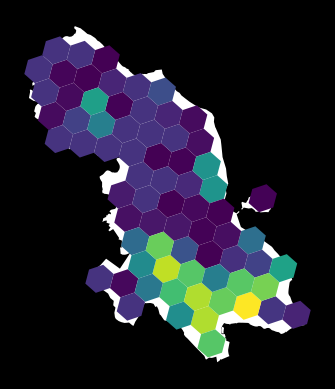

In [8]:
place_name = 'Konstanz, Germany'
city = Place(place_name)
city.load_population()
city.plot_population()